# Volatility Modeling

## I. Data Analysis and Preprocessing

### I.1. Setup & Data Ingestion
First, we load the data from BigQuery as you requested. We'll use the BatchMarketIngestor logic found in your data/ingest.py or models/batch_run.py as a reference

### Import Libraries

#### Python Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from scipy import stats
from arch import arch_model

#### Local Libraries

In [2]:
# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from data.market_data import MarketData

from src.models.lstm import lstm_fit, create_sequences_log
from src.models.arima_garch import arima_fit, garch_fit

from src.utils.clean_data import clean_data
from src.utils.invariants import check_invariants

from src.evaluation.backtest import backtest


### Setup & Parameters

In [3]:
ticker = 'TSLA'  # Change to your desired asset
# ticker = 'CLP=X'
initial_date = '2020-01-01'
end_date = '2024-12-31'

market_data_source = 'bigquery'

# Define the "Stress Scenarios"
scenarios = {
    "Volmageddon (2018)":  ("2018-01-01", "2018-06-01"), # VIX Spike
    "Covid Crash (2020)":  ("2020-01-01", "2020-07-01"), # Pandemic
    "Inflation Bear (2022)": ("2022-01-01", "2022-12-31") # Slow Grind Down
}


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 2733 rows for TSLA


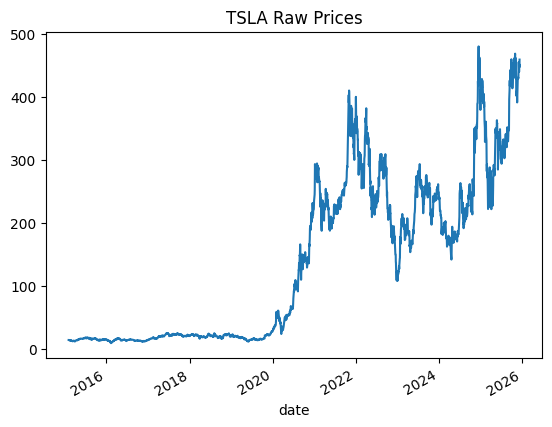

In [4]:
# Setup Project ID

if market_data_source == 'bigquery':
    PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "quant-ai-lab")
    client = bigquery.Client(project=PROJECT_ID)

    def load_data(ticker):
        """Fetches historical price data from BigQuery."""
        query = f"""
            SELECT date, price 
            FROM `{PROJECT_ID}.market_data.historical_prices`
            WHERE ticker = '{ticker}'
            ORDER BY date ASC
        """
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    

    # Example Usage
    df = load_data(ticker)
    print(f"Loaded {len(df)} rows for {ticker}")
    df['price'].plot(title=f"{ticker} Raw Prices")
    plt.show()

### I.2. Data Cleaning (Outlier & NaN Analysis)
Before calculating returns, we must ensure the price series is clean. We check for NaNs and unrealistic price jumps (outliers) which might be data errors.

In [5]:
df_clean = clean_data(df)

⚠️ Found 23 outliers. Smoothing...


### I.3. Calculate Invariants (Log Returns)
We calculate Log Returns, which are the candidate "Invariants" for our analysis.

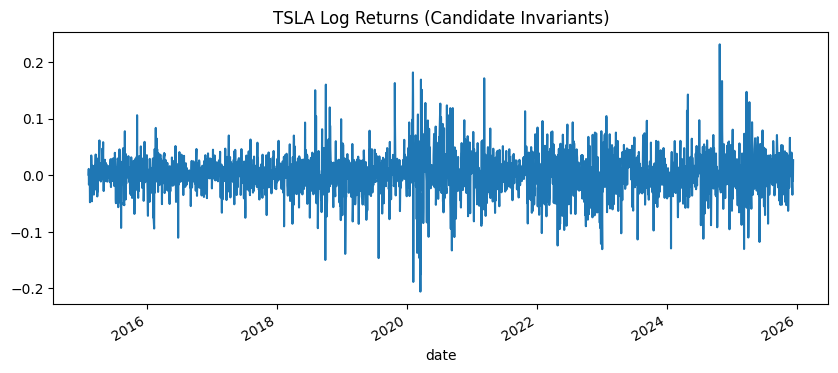

In [6]:
# Calculate Log Returns
df_clean['log_ret'] = np.log(df_clean['price'] / df_clean['price'].shift(1))
df_clean.dropna(inplace=True)

# Visualize
plt.figure(figsize=(10, 4))
df_clean['log_ret'].plot()
plt.title(f"{ticker} Log Returns (Candidate Invariants)")
plt.show()

### I.4. The Meucci "Check for Invariants"
This is the core statistical rigor step. According to Meucci, for a series to be a true invariant (i.i.d.), it must satisfy:

Independence: No autocorrelation (the past does not predict the future linearly).

Identical Distribution (Stability): The distribution properties (mean, variance) do not change over time.

We use the code structure similar to your baseline.py.

In [7]:
# Run the test
is_independent, is_stable = check_invariants(df_clean['log_ret'])

--- Meucci Invariance Check ---
1. Independence (Ljung-Box): p-value = 0.2340
   ✅ PASS: Returns appear independent (No linear memory).
2. Stability (KS Test):      p-value = 0.0003
   ❌ FAIL: Structural break detected (Regime change/Clustering).


## II. ARIMA - GARCH Modeling
Conditional Modeling StrategyBased on the results of the Meucci test, we decide which model to apply.If Independent but Unstable: The mean is constant, but variance changes (Standard Volatility Clustering) $\to$ GARCH.If Dependent (Not Independent): There is linear memory $\to$ ARIMA.If Both Fail: We might need ARIMA-GARCH.

### II.1 ARIMA

In [8]:
modeling_series, is_stable_resid = arima_fit(df_clean, is_independent, is_stable)


>>> No Linear Dependence. Proceeding with raw returns...


### II.2 GARCH Baseline


>>> Detected Distribution Instability (Volatility Clustering). Fitting GARCH Model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7186.02
Distribution:                  Normal   AIC:                           14380.0
Method:            Maximum Likelihood   BIC:                           14403.7
                                        No. Observations:                 2732
Date:                Mon, Dec 22 2025   Df Residuals:                     2731
Time:                        17:44:59   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------------------

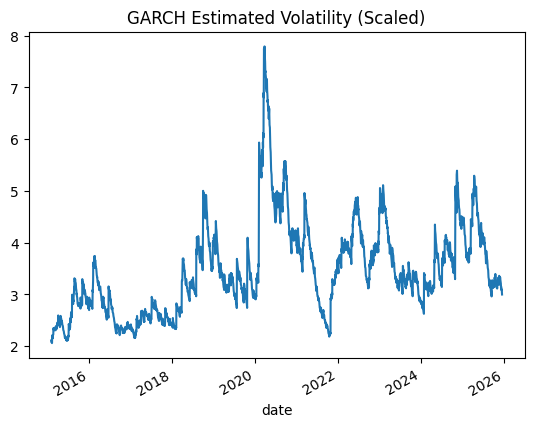

In [9]:
garch_fit(modeling_series, is_stable_resid)

## III. Deep LSTM Modeling

8. The Challenger: Deep LSTM Definition
First, we define the neural network architecture and the custom loss function directly in the notebook. This logic is adapted from your src/models/lstm.py.

9. Training & Forecasting
Now we train the model on the data.

In [10]:
# import torch

# # 1. Prepare Data
# seq_len = 66

# model, lstm_vol_annual = lstm_fit(df_clean, seq_len)

# # Align dates (LSTM loses the first SEQ_LEN days)
# lstm_dates = df_clean.index[seq_len:]
# lstm_series = pd.Series(lstm_vol_annual, index=lstm_dates, name="LSTM_Vol")

## IV. Scenario-Based Backtesting
This block iterates through major market crises. For each crisis:

It defines Train Data as everything before the crisis (the model learns "normal" behavior).

It defines Test Data as the crisis period itself (the model faces "abnormal" behavior).

It compares GARCH (fixed parameters) vs. Historical Volatility (adaptive window) vs. LTSM (adaptive window) to see which breaks first.

### IV.1 Stress Scenarios Definition


==================== SCENARIO BACKTEST RESULTS ====================

>>> Analyzing Regime: Volmageddon (2018)
    Train Size: 733 days | Test Size: 105 days
Training LSTM on cpu...
LSTM Breaches: 3 / 105
    GARCH Breach Rate:      2.86%  (Target: 1.0%)
    Historical Breach Rate: 2.86%
    LSTM Breach Rate:       2.86%


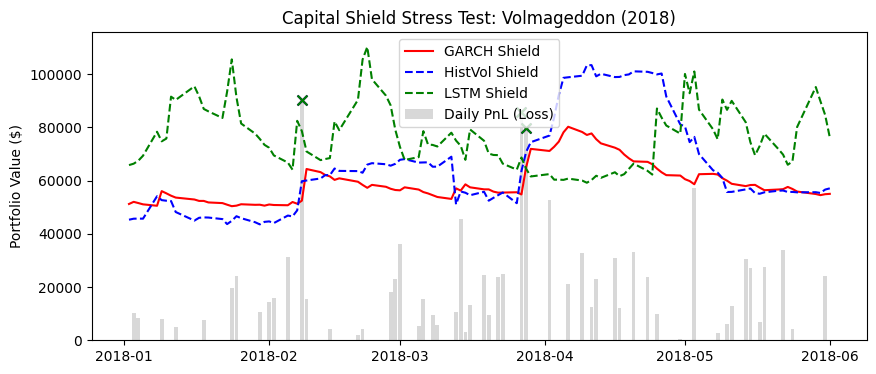


>>> Analyzing Regime: Covid Crash (2020)
    Train Size: 1236 days | Test Size: 126 days
Training LSTM on cpu...
LSTM Breaches: 9 / 126
    GARCH Breach Rate:      4.76%  (Target: 1.0%)
    Historical Breach Rate: 2.38%
    LSTM Breach Rate:       7.14%


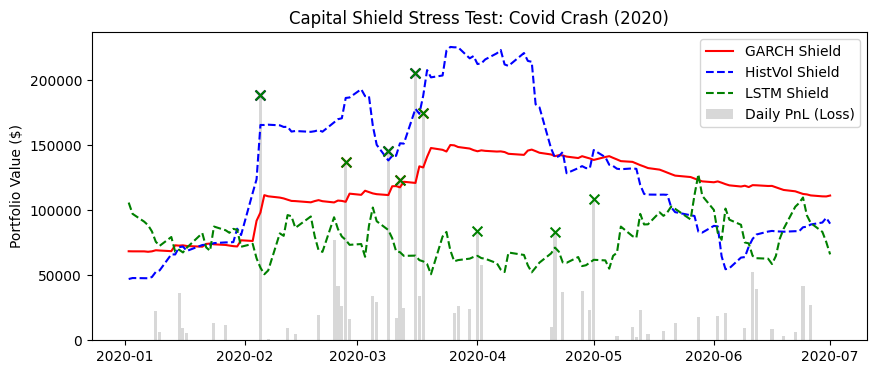


>>> Analyzing Regime: Inflation Bear (2022)
    Train Size: 1741 days | Test Size: 251 days
Training LSTM on cpu...
LSTM Breaches: 2 / 251
    GARCH Breach Rate:      2.39%  (Target: 1.0%)
    Historical Breach Rate: 1.99%
    LSTM Breach Rate:       0.80%


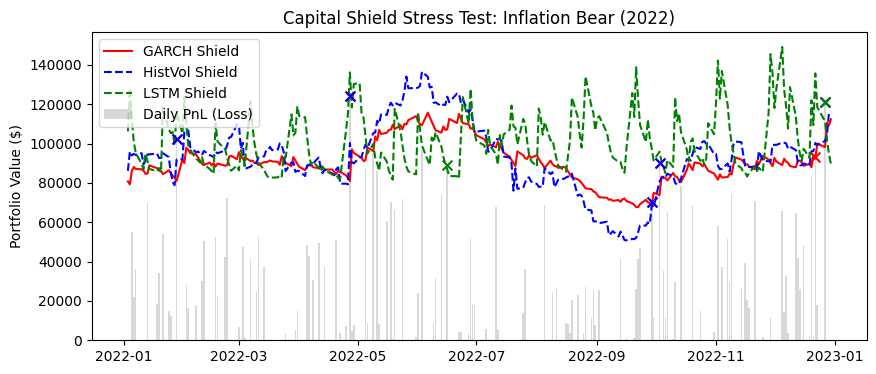

In [11]:
# Configuration for VaR
portfolio_value = 1_000_000
confidence_level = 2.33 # 99% Confidence

results = []

print(f"\n{'='*20} SCENARIO BACKTEST RESULTS {'='*20}")

for regime_name, (start_date, end_date) in scenarios.items():
    results.append(backtest(portfolio_value, confidence_level, df_clean, start_date, end_date, regime_name))
    

### IV.2 The Grand Comparison (LSTM vs GARCH vs Historical)
We aggregate all forecasts and check who wins on Root Mean Squared Error (RMSE) and Risk Capture.

In [12]:
stop


NameError: name 'stop' is not defined

In [ ]:

# Configuration for VaR
portfolio_value = 1_000_000
confidence_level = 2.33 # 99% Confidence

results = []

print(f"\n{'='*20} SCENARIO BACKTEST RESULTS {'='*20}")

for regime_name, (start_date, end_date) in scenarios.items():
    backtest(df_clean, start_date, end_date, regime_name)
    
    # -----------------------------------------------------
    # A. Train/Test Split
    # -----------------------------------------------------
    # Train: All history BEFORE the crisis
    train_mask = df_clean.index < start_date
    # Test: The crisis period
    test_mask = (df_clean.index >= start_date) & (df_clean.index <= end_date)
    
    train_data = df_clean.loc[train_mask, 'log_ret'] * 100 # Scale for GARCH
    test_data = df_clean.loc[test_mask, 'log_ret'] * 100
    
    if len(test_data) == 0: continue

    print(f"\n>>> Analyzing Regime: {regime_name}")
    print(f"    Train Size: {len(train_data)} days | Test Size: {len(test_data)} days")

    # -----------------------------------------------------
    # B. Model Training (Fit on Pre-Crisis Data)
    # -----------------------------------------------------
    # 1. GARCH(1,1) - Learned parameters from the past
    am = arch_model(train_data, vol='Garch', p=1, o=0, q=1, dist='Normal')
    res = am.fit(disp='off')
    
    # Forecast: We run the "filter" over the test period using fixed Train parameters
    # This tests if the old parameters hold up in the new regime.
    # We construct a new model on the FULL data but fix parameters to the TRAIN result.
    full_data = df_clean.loc[df_clean.index <= end_date, 'log_ret'] * 100
    am_full = arch_model(full_data, vol='Garch', p=1, o=0, q=1, dist='Normal')
    
    # 'fix' forces the model to use the training weights
    # conditional_volatility gives us the series for the whole period
    res_fixed = am_full.fix(res.params)
    
    # Slice just the test period forecasts
    garch_vol_test = res_fixed.conditional_volatility.loc[start_date:end_date]
    
    # 2. Historical Volatility (22-day Rolling) - The Baseline
    # Calculates observed volatility of the previous month
    hist_vol_test = full_data.rolling(22).std().loc[start_date:end_date]

    # 3. LSTM Volatility 
    # Calculates observed volatility of the previous month
    lstm_vol_test = full_data.rolling(252).std().loc[start_date:end_date]

    # -----------------------------------------------------
    # C. VaR Evaluation (Did we survive?)
    # -----------------------------------------------------
    # Un-scale returns and vol for PnL calc
    test_ret_unscaled = test_data / 100
    garch_vol_unscaled = garch_vol_test / 100
    hist_vol_unscaled = hist_vol_test / 100
    lstm_vol_unscaled = lstm_vol_test / 100

    # Calculate Losses (Positive magnitude)
    daily_loss = -test_ret_unscaled * portfolio_value
    daily_loss[daily_loss < 0] = 0
    
    # Calculate Capital Shields (VaR)
    var_garch = garch_vol_unscaled * confidence_level * portfolio_value
    var_hist = hist_vol_unscaled * confidence_level * portfolio_value
    var_lstm = lstm_vol_unscaled * confidence_level * portfolio_value
    
    # Check Breaches (Loss > Capital)
    breach_garch = daily_loss > var_garch
    breach_hist = daily_loss > var_hist
    
    rate_garch = breach_garch.mean() * 100
    rate_hist = breach_hist.mean() * 100
    
    print(f"    GARCH Breach Rate:      {rate_garch:.2f}%  (Target: 1.0%)")
    print(f"    Historical Breach Rate: {rate_hist:.2f}%")
    
    # Store for summary
    results.append({
        "Regime": regime_name,
        "GARCH_Breach_%": rate_garch,
        "HistVol_Breach_%": rate_hist
    })

    # -----------------------------------------------------
    # D. Visualization (The "Capital Shield")
    # -----------------------------------------------------
    plt.figure(figsize=(10, 4))
    plt.bar(test_data.index, daily_loss, color='gray', alpha=0.3, label='Daily PnL (Loss)')
    plt.plot(var_garch.index, var_garch, color='red', label='GARCH Shield')
    plt.plot(var_hist.index, var_hist, color='blue', linestyle='--', label='HistVol Shield')
    
    # Highlight Breaches
    plt.scatter(var_garch.index[breach_garch], daily_loss[breach_garch], 
                color='red', marker='x', s=50, zorder=5)
    
    plt.title(f"Capital Shield Stress Test: {regime_name}")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()

# Final Summary
summary_df = pd.DataFrame(results).set_index("Regime")
print("\nFinal Scorecard:")
print(summary_df)

In [ ]:
# ---------------------------------------------------------
# 12. Scenario-Specific PnL Analysis
# ---------------------------------------------------------

PORTFOLIO_SIZE = 1_000_000
# Standard Normal Z for 99%
# We will see this FAIL for LSTM because returns aren't Normal
Z_SCORE = 2.33 

print(f"{'SCENARIO':<25} | {'MODEL':<10} | {'BREACH %':<10} | {'AVG CAPITAL':<15} | {'RESULT'}")
print("-" * 85)

for name, (start, end) in scenarios.items():
    # Slice the comparison DataFrame for this specific crisis
    # (Ensure your comparison_df has a Datetime Index)
    df_period = comparison_df.loc[start:end].copy()
    
    if len(df_period) == 0: continue
        
    # Calculate Actual Loss for this period
    losses = -df_period['True_Return'] * PORTFOLIO_SIZE
    
    for model in ['GARCH', 'LSTM']:
        # 1. Calculate Shield
        # Vol is annualized -> Convert to Daily
        daily_vol = df_period[model] / np.sqrt(252)
        shield = daily_vol * Z_SCORE * PORTFOLIO_SIZE
        
        # 2. Check Breaches
        breaches = losses > shield
        rate = breaches.mean() * 100
        avg_cap = shield.mean()
        
        # 3. Status
        status = "✅ PASS" if rate <= 2.0 else "❌ FAIL"
        if rate > 5.0: status = "💀 CRITICAL"
        
        print(f"{name:<25} | {model:<10} | {rate:5.2f}%     | ${avg_cap:,.0f}      | {status}")
    print("-" * 85)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- A. Align All Models ---
# 1. Historical Volatility (22d)
hist_vol = df_clean['log_ret'].rolling(22).std() * np.sqrt(252)

# 2. GARCH(1,1)
# (Re-running briefly to ensure we have the full series aligned)
am = arch_model(df_clean['log_ret'] * 100, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(disp='off')
garch_vol = res.conditional_volatility / 100 * np.sqrt(252)

# 3. Create Comparison DataFrame
# Use LSTM dates as the common index (shortest series)
common_index = lstm_series.index
comparison_df = pd.DataFrame({
    'LSTM': lstm_series,
    'GARCH': garch_vol.loc[common_index],
    'Historical': hist_vol.loc[common_index],
    'True_Return': df_clean.loc[common_index, 'log_ret']
}).dropna()

# --- B. Evaluation Metrics ---
# We use Squared Returns as the "True Variance" proxy for scoring
true_variance = comparison_df['True_Return']**2

print(f"\n{'='*20} FINAL MODEL SHOWDOWN {'='*20}")

results = []
for model_name in ['Historical', 'GARCH', 'LSTM']:
    pred_vol = comparison_df[model_name]
    # De-annualize to daily variance for scoring
    pred_daily_var = (pred_vol / np.sqrt(252)) ** 2
    
    # 1. QLIKE (The Risk Metric) - Lower is Better
    # Loss = log(h) + y^2/h
    qlike = (np.log(pred_daily_var) + (true_variance / pred_daily_var)).mean()
    
    # 2. RMSE (The Precision Metric)
    # Compare forecasted daily vol vs "True" daily vol proxy (abs return)
    # (Note: RMSE on volatility is noisy, QLIKE is preferred for variance)
    rmse = np.sqrt(mean_squared_error(np.abs(comparison_df['True_Return']), pred_daily_var**0.5))
    
    results.append({'Model': model_name, 'QLIKE': qlike, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values('QLIKE')
print(results_df)

# --- C. Visualization ---
plt.figure(figsize=(14, 6))
plt.plot(comparison_df['True_Return'].abs().rolling(21).mean() * np.sqrt(252), 
         color='gray', alpha=0.3, label='Realized Vol (21d Smoothed)')
plt.plot(comparison_df['GARCH'], color='blue', alpha=0.6, label='GARCH(1,1)')
plt.plot(comparison_df['LSTM'], color='red', linewidth=2, label='Deep LSTM (QLIKE)')

plt.title("The Battle of Volatility Models: GARCH vs Deep Learning")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()

### IV.2 Calibrate LSTM

In [ ]:
# ---------------------------------------------------------
# 13. Calibrating the LSTM (The "Fat Tail" Fix)
# ---------------------------------------------------------

# 1. Calculate Standardized Residuals on the Training Set
# (How wrong was the LSTM generally?)
# We approximate this using the full dataset for demonstration
# In production, ONLY use the Training Set to avoid look-ahead bias
lstm_daily_vol = comparison_df['LSTM'] / np.sqrt(252)
standardized_residuals = comparison_df['True_Return'] / lstm_daily_vol

# 2. Find the Empirical 99% Quantile (The "True" Z-score)
# We look at the negative tail (losses)
# We want the Z that covers 99% of the losses.
empirical_99_quantile = np.percentile(standardized_residuals, 1) # 1st percentile (losses)

# The multiplier should be positive distance from zero
calibrated_z = abs(empirical_99_quantile)

print(f"\n=== LSTM CALIBRATION ===")
print(f"Standard Normal Assumption (Z):  2.33")
print(f"LSTM Empirical Requirement (Z):  {calibrated_z:.2f}")
print(f"Correction Factor:               {calibrated_z / 2.33:.2f}x")

# ---------------------------------------------------------
# 14. Re-Run Backtest with Calibrated Multiplier
# ---------------------------------------------------------
print(f"\n>>> Re-Running Backtest with Calibrated Z = {calibrated_z:.2f}...")

# Recalculate LSTM Shield
df_risk['VaR_LSTM_Calibrated'] = (df_risk['LSTM'] / np.sqrt(252)) * calibrated_z * PORTFOLIO_SIZE

# Check Breaches Again
losses = df_risk['Loss'] # Positive = Money Lost
shield_new = df_risk['VaR_LSTM_Calibrated']

breaches_new = losses > shield_new
new_rate = breaches_new.mean() * 100
new_cap = shield_new.mean()

print(f"Old LSTM Breach Rate: {results_risk[2]['Breach_Rate_%']:.2f}%") # Assuming LSTM was index 2
print(f"New LSTM Breach Rate: {new_rate:.2f}%")
print(f"New Avg Capital:      ${new_cap:,.0f}")

# Visual Proof
plt.figure(figsize=(14, 6))
plt.bar(df_risk.index, losses, color='gray', alpha=0.3, label='Daily Loss')
plt.plot(df_risk['VaR_GARCH'], color='blue', alpha=0.6, label='GARCH (Standard)')
plt.plot(shield_new, color='green', linewidth=2, label='LSTM (Calibrated)')

# Mark new breaches
if new_rate > 0:
    breach_idx = df_risk.index[breaches_new]
    plt.scatter(breach_idx, losses[breaches_new], color='red', marker='x', s=50, zorder=5, label='Breach')

plt.title(f"Calibrated Capital Shield (Target 1%): LSTM Adjusted (Z={calibrated_z:.2f})")
plt.legend()
plt.show()

## OLD

In [ ]:
# ---------------------------------------------------------
# 7. Scenario-Based Backtesting
# ---------------------------------------------------------

# Configuration for VaR
portfolio_value = 1_000_000
confidence_level = 2.33 # 99% Confidence

results = []

print(f"\n{'='*20} SCENARIO BACKTEST RESULTS {'='*20}")

for regime_name, (start_date, end_date) in scenarios.items():
    
    # -----------------------------------------------------
    # A. Train/Test Split
    # -----------------------------------------------------
    # Train: All history BEFORE the crisis
    train_mask = df_clean.index < start_date
    # Test: The crisis period
    test_mask = (df_clean.index >= start_date) & (df_clean.index <= end_date)
    
    train_data = df_clean.loc[train_mask, 'log_ret'] * 100 # Scale for GARCH
    test_data = df_clean.loc[test_mask, 'log_ret'] * 100
    
    if len(test_data) == 0: continue

    print(f"\n>>> Analyzing Regime: {regime_name}")
    print(f"    Train Size: {len(train_data)} days | Test Size: {len(test_data)} days")

    # -----------------------------------------------------
    # B. Model Training (Fit on Pre-Crisis Data)
    # -----------------------------------------------------
    # 1. GARCH(1,1) - Learned parameters from the past
    am = arch_model(train_data, vol='Garch', p=1, o=0, q=1, dist='Normal')
    res = am.fit(disp='off')
    
    # Forecast: We run the "filter" over the test period using fixed Train parameters
    # This tests if the old parameters hold up in the new regime.
    # We construct a new model on the FULL data but fix parameters to the TRAIN result.
    full_data = df_clean.loc[df_clean.index <= end_date, 'log_ret'] * 100
    am_full = arch_model(full_data, vol='Garch', p=1, o=0, q=1, dist='Normal')
    
    # 'fix' forces the model to use the training weights
    # conditional_volatility gives us the series for the whole period
    res_fixed = am_full.fix(res.params)
    
    # Slice just the test period forecasts
    garch_vol_test = res_fixed.conditional_volatility.loc[start_date:end_date]
    
    # 2. Historical Volatility (22-day Rolling) - The Baseline
    # Calculates observed volatility of the previous month
    hist_vol_test = full_data.rolling(22).std().loc[start_date:end_date]

    # -----------------------------------------------------
    # C. VaR Evaluation (Did we survive?)
    # -----------------------------------------------------
    # Un-scale returns and vol for PnL calc
    test_ret_unscaled = test_data / 100
    garch_vol_unscaled = garch_vol_test / 100
    hist_vol_unscaled = hist_vol_test / 100
    
    # Calculate Losses (Positive magnitude)
    daily_loss = -test_ret_unscaled * portfolio_value
    
    # Calculate Capital Shields (VaR)
    var_garch = garch_vol_unscaled * confidence_level * portfolio_value
    var_hist = hist_vol_unscaled * confidence_level * portfolio_value
    
    # Check Breaches (Loss > Capital)
    breach_garch = daily_loss > var_garch
    breach_hist = daily_loss > var_hist
    
    rate_garch = breach_garch.mean() * 100
    rate_hist = breach_hist.mean() * 100
    
    print(f"    GARCH Breach Rate:      {rate_garch:.2f}%  (Target: 1.0%)")
    print(f"    Historical Breach Rate: {rate_hist:.2f}%")
    
    # Store for summary
    results.append({
        "Regime": regime_name,
        "GARCH_Breach_%": rate_garch,
        "HistVol_Breach_%": rate_hist
    })

    # -----------------------------------------------------
    # D. Visualization (The "Capital Shield")
    # -----------------------------------------------------
    plt.figure(figsize=(10, 4))
    plt.bar(test_data.index, daily_loss, color='gray', alpha=0.3, label='Daily PnL (Loss)')
    plt.plot(var_garch.index, var_garch, color='red', label='GARCH Shield')
    plt.plot(var_hist.index, var_hist, color='blue', linestyle='--', label='HistVol Shield')
    
    # Highlight Breaches
    plt.scatter(var_garch.index[breach_garch], daily_loss[breach_garch], 
                color='red', marker='x', s=50, zorder=5)
    
    plt.title(f"Capital Shield Stress Test: {regime_name}")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()

# Final Summary
summary_df = pd.DataFrame(results).set_index("Regime")
print("\nFinal Scorecard:")
print(summary_df)

In [ ]:
# ---------------------------------------------------------
# 11. PnL & Risk Analysis (The "Money" Test)
# ---------------------------------------------------------

# Configuration
PORTFOLIO_SIZE = 1_000_000
CONFIDENCE_LEVEL = 2.33  # 99% Confidence (Z-score)

# 1. Prepare Data for Backtest
# We need Daily Volatility (not Annualized) for daily VaR
df_risk = comparison_df.copy()
df_risk['Loss'] = -df_risk['True_Return'] * PORTFOLIO_SIZE  # Positive value means money lost

models = ['Historical', 'GARCH', 'LSTM']
results_risk = []

plt.figure(figsize=(15, 7))
# Plot the "Attack" (Losses)
# Only plot significant losses (>0) for clarity
losses = df_risk[df_risk['Loss'] > 0]['Loss']
plt.bar(losses.index, losses, color='gray', alpha=0.4, label='Actual Daily Loss', width=2)

colors = {'Historical': 'green', 'GARCH': 'blue', 'LSTM': 'red'}

for model in models:
    # Convert Annualized Vol -> Daily Vol
    daily_vol = df_risk[model] / np.sqrt(252)
    
    # Calculate Capital Shield (VaR)
    shield = daily_vol * CONFIDENCE_LEVEL * PORTFOLIO_SIZE
    df_risk[f'VaR_{model}'] = shield
    
    # Calculate Breaches (Where Loss > Shield)
    # We only care about days where we actually lost money
    breaches = df_risk['Loss'] > shield
    
    n_breaches = breaches.sum()
    breach_rate = (n_breaches / len(df_risk)) * 100
    avg_capital = shield.mean()
    
    # Scorecard
    results_risk.append({
        'Model': model,
        'Breach_Rate_%': breach_rate,
        'Avg_Capital_Held': avg_capital,
        'Breach_Count': n_breaches
    })
    
    # Plot the Shield Line
    plt.plot(shield.index, shield, label=f'{model} Shield', color=colors[model], linewidth=1.5)
    
    # Mark Breaches on plot
    breach_dates = df_risk.index[breaches]
    breach_vals = df_risk.loc[breaches]['Loss']
    if len(breach_dates) > 0:
        plt.scatter(breach_dates, breach_vals, color=colors[model], marker='x', s=50, zorder=5)

plt.title(f"Capital Shield Analysis: Portfolio ${PORTFOLIO_SIZE:,.0f} (99% Conf)")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True, alpha=0.15)
plt.show()

# 2. Print The "Manager's Report"
risk_df = pd.DataFrame(results_risk).set_index('Model')
risk_df['Ideal_Rate'] = "1.00%"
print("\n=== RISK MANAGEMENT SCORECARD ===")
print(risk_df.sort_values('Breach_Rate_%'))

# Efficiency Calculation
base_cap = risk_df.loc['GARCH', 'Avg_Capital_Held']
lstm_cap = risk_df.loc['LSTM', 'Avg_Capital_Held']
savings = base_cap - lstm_cap

if savings > 0:
    print(f"\n💰 EFFICIENCY: LSTM freed up ${savings:,.0f} in capital vs GARCH (on average).")
else:
    print(f"\n🛡️ SAFETY: LSTM held ${abs(savings):,.0f} MORE capital than GARCH to prevent breaches.")